# Reservoir Network - River Regulation due to Reservoir Operations

## Summary
In this project, I had set out to model the river flow regulation due to reservoir operations. Reservoirs (behind dams), usually store water before (and during) the wet season, where there is higher flow in the river, and release water during drier periods. This also depends heavily on the primary use of the reservoirs – either Irrigation, Hydropower or Flood control. The final stage of the project will be to use satellite derived storage change estimates of reservoirs, and modeled natural inflow. 

## Model Architecture
In order to model the reservoir operations based river regulation, I wrote a landlab component, called `StreamFlowRegulation`. 
- It models the river network using the `NetworkGridModel`. 
- The nodes represent the reservoirs, and the links between them represent the river in between.

### Node and Link Fields in the NetworkGridModel
1. Each node (reservoir) has the following fields:
    - `reservoir__total_inflow` - Total incoming flow to reservoir ($I$) - Ideally, this will be the total modeled inflow to the reservoir without the effect of any upstream reservoirs.
    - `reservoir__storage_change` - Storage change of the reservoir ($\Delta S$) - The estimated/observed storage change of the reservoir.
    - `reservoir__release` - Outflow/release from the reservoir ($O$) - calculated as follows: $O = I - \Delta S$.
    - `reservoir__regulated_inflow` ($I_{reg}$) and `reservoir__unregulated_inflow` ($I_{unreg}$) - The inflow coming to the reservoir due to upstream release events, and the inflow to the reservoir that is not affected by upstream reservoir operations, respectively.
    - `reservoir__abstract_elevation` - While exploring the creation of components and figuring out how the model will function, I was using this field to figure out the direction of flow in the reservoir network. This can be set equal to the actual elevation of the reservoirs from a DEM, or set equal to the `topograhic__elevation`. NODTEIn the next few updates to the project this field will be merged wioth the `topographic__elevation`
2. Each link (river section connecting two reservoirs) has the following fields:
    - `river__storage` - The storage of a river secion ($S_{river}$) - A linear storage routing algorithm is used in the component to model the river behavior and its flow, (Wigmosta and Lettenmaier, 1994; Wigmosta et al., 2002). This field is used to store the storage values of the river. The model is described more thoroughly in the following sections.
    - `river__hydraulic_radius` - This denotes the Hydraulic Radius of the river that is required for the linear storage model calculations.
    - `river__release_inflow` - This is the inflow of water into the river section due to release from the upstream reservoir. 
    - `river__slope` and `river__length` - These are the slope and length of the river section.
    - `river__roughness` - This field describes the value of Manning's n for a river section.

## How does the Component work?
1. The component needs a `NetworkModelGrid` with the input fields already populated, which can be done using necessary assumptions. The fields related to fluxes (inflow, release, storage change, etc.) can be initiated with `np.nan` values, although they will be replaced later with calculated and other input values.
2. When an object of the component is created, it's `__init__` function is called, which initializes the input and output fields. It also stores internal references to individual fields.
3. The component is run by using the `Obj.run_one_step(time, inflow, storage_change)` method, where the `Obj` is the object of our component. The following processes take place when the `run_one_step` is called:
    1. The function requires the `inflow` and `storage_change` of the reservoirs as inputs. 
    2. First, it sets the values of the respective fields in the internal grid of the component. 
    3. The the outflow calculation function is called: This function calculates the outflow from each reservoir based on the inflow and storage change using the following equation - $O = I - \Delta S$.
    4. The calculated Outflow, $O$, is then routed through the river section. This is done using the linear storage routing algorithm (Wigmosta and Lettenmaier, 1994; Wigmosta et al., 2002). The Volume discharge at the end of the time-step is calculated as: $V_{c}^{t+\Delta t} = \frac{Q_{in}}{k} + (V_c^t - \frac{Q_{in}}{k}) e^{-k \Delta t}$, where $V_{c}^{t+\Delta t}$ is the discharge of water, $V_{c}^{t}$ is the existing volume of water, and $k$ is the storage parameter.
    5. The $k$ paramter is calcualted can estimating the velocity of flow using the Manning's roughness coefficient method. $k = R_r^{\frac{2}{3}} \sqrt{S_o}/(nL)$.
    6. Once all the link discharges are calculated, the inflow due to all these river sections are calculated for their downstream reservoirs. For this, the `FlowDirectorSteepest` component is used to first find the direction of flow based on the `reservoir__abstract_elevation` (where the `topographic__elevation` can be used). Then, all the contributing river sections are identified, and the outflows from those river sections are added up. This gives us the `reservoir__regulated_inflow` into the reservoir.
    7. Finally, the unregulated flow is calculated cby subtracting the regulated inflow from the total inflow.
4. In summary, the component takes in the Total Inflow, and Storage change, and returns the partitioned regulated and unregulated flows into the reservoir, and along the corresponding river fluxes.

## Code follows below with example data and running the component

# Defining the `StreamflowRegulation` Component

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd

from landlab import Component, FieldError
from landlab.components import FlowDirectorSteepest
from landlab.grid.mappers import map_link_head_node_to_link

class StreamflowRegulation(Component):
    """_brief_summary_

    _detailed_summary_

    Construction:
        
        Component (_type_): _description_

    Parameters
    ----------
        fluxes: DataRecord that has modeled total inflow and storage change for each reservoir in 
                the network
    """
    _name = "StreamflowRegulation"

    _unit_agnostic = False

    _info = {
        "reservoir__total_inflow": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m3/d",
            "mapping": "node"
        },
        "reservoir__storage_change": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m3/d",
            "mapping": "node"
        },
        "reservoir__release": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m3/d",
            "mapping": "node"
        },
        "reservoir__regulated_inflow": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m3/d",
            "mapping": "node"
        },
        "reservoir__unregulated_inflow": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m3/d",
            "mapping": "node"
        },
        "reservoir__abstract_elevation": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m",
            "mapping": "node"
        },
        "river__storage": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m3",
            "mapping": "link"
        },
        "river__hydraulic_radius": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m",
            "mapping": "link"
        },
        "river__release_inflow": {
            "dtype": float,
            "intent": "out",
            "optional": False,
            "units": "m3/d",
            "mapping": "link"
        },
        "river__slope": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m/m",
            "mapping": "link"
        },
        "river__length": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "m",
            "mapping": "link"
        },
        "river__roughness": {
            "dtype": float,
            "intent": "in",
            "optional": False,
            "units": "-",
            "mapping": "link"
        }
    }

    def __init__(
        self, grid#, fluxes
    ):
        """_summary_

        Args:
            grid (_type_): _description_
            start_time (_type_): _description_
        """
        super().__init__(grid)

        # self._grid = grid

        self.initialize_output_fields()
        
        # self._fluxes = fluxes

        self._time = 0
        self._time_idx = 0

        self._inflow = grid.at_node["reservoir__total_inflow"]
        self._abstract_elevation = grid.at_node["reservoir__abstract_elevation"]
        self._storage_change = grid.at_node["reservoir__storage_change"]

        self._time_variable_flux_attributes = [
            "modeled_inflow",
            "storage_change"
        ]


    def _calc_outflow(self):
        """Calculates outflow using mass balance: O = I - ∆S
        """
        self._outflow = self._grid.at_node['reservoir__total_inflow'] - self._grid.at_node['reservoir__storage_change']
        self._grid.at_node['reservoir__release'] = self._outflow
        
        return self._outflow

    # def _create_new_time(self):
    #     """_summary_
    #     """
    #     if self._time_idx != 0:
    #         self._fluxes.add_record(time=[self._time])
            
    #         self._fluxes.ffill_grid_element_and_id()

    #         # copy parcel attributes forward in time.
    #         for at in self._time_variable_flux_attributes:
    #             self._fluxes.dataset[at].values[
    #                 :, self._time_idx
    #             ] = self._fluxes.dataset[at].values[:, self._time_idx - 1]

    #     self._this_timesteps_fluxes = np.zeros_like(
    #         self._fluxes.dataset.element_id, dtype=bool
    #     )
    #     self._this_timesteps_fluxes[:, -1] = True


    def _calc_regulated_inflow(self):
        """Calculates the upstream inflow
        """
        # flow director needed for finding upstream nodes. Use the abstract_elevation field which
        # can have any abstract value, with the end node having the lowest abstract_elevation, and
        # increasing upstream
        fdr = FlowDirectorSteepest(self._grid, self._abstract_elevation)
        fdr.run_one_step()

        # find the links that contribute to each node
        upstream_contributing_links_at_node = np.where(
            fdr.flow_link_incoming_at_node() == 1, self._grid.links_at_node, -1
        )

        # # find upstream links
        # upstream_links = ma.MaskedArray(
        #     upstream_contributing_links_at_node, 
        #     mask=upstream_contributing_links_at_node==-1
        # )
        # # find upstream nodes
        # upstream_nodes = ma.MaskedArray(
        #     fdr.upstream_node_at_link()[upstream_links], 
        #     mask=upstream_links.mask
        # )
        
        # calculate regulated inflow as the sum of release for now, later use links and link 
        # storage to calculate regulated inflow
        self._grid.at_link['river__regulated_flow']
        regulated_inflow = ma.sum(
            ma.MaskedArray(
                self._grid.at_link['river__regulated_flow'].reshape(-1, 1)[upstream_contributing_links_at_node],
                mask = upstream_contributing_links_at_node == -1
            ), axis=1 
        ).filled(0)

        self._grid.at_node['reservoir__regulated_inflow'] = regulated_inflow

        return regulated_inflow

    def _calc_unregulated_inflow(self):
        """Calculates the unregulated inflow reaching a reservoir
        """
        total_inflow = self._grid.at_node['reservoir__total_inflow']
        regulated_inflow = self._grid.at_node['reservoir__regulated_inflow']

        unregulated_inflow = total_inflow - regulated_inflow
        self._grid.at_node['reservoir__unregulated_inflow'] = unregulated_inflow

        return unregulated_inflow

    def _calc_k(self):
        return np.power(self._grid.at_link["river__hydraulic_radius"], 2/3) * np.sqrt(self._grid.at_link["river__slope"])/(self._grid.at_link["river__roughness"]*self._grid.at_link["river__length"])
    
    def _route_through_stream(self):
        """Calculate inflow to river
        """
        # Qin = self._grid.at_node["reservoir__release"][self._grid.node_at_link_head])
        Qin = map_link_head_node_to_link(self._grid, "reservoir__release")
        self._grid.at_link["river__release_inflow"] = Qin
        
        V_t = self._grid.at_link["river__storage"]

        k = self._calc_k()

        V_t_1 = (Qin/k) + (V_t - Qin/k) * np.exp(-k) # ∆t = 1
        self._grid.at_link["river__storage"] = V_t_1

        # calculate outflow to next node
        Qout = Qin - (V_t_1 - V_t)
        self.grid.at_link["river__regulated_flow"] = Qout

        return Qout
    
    def _calc_upstream_storage_change(self):
        """Calculate cumulative upstream storage change
        """
        # flow director needed for finding upstream nodes. Use the abstract_elevation field which
        # can have any abstract value, with the end node having the lowest abstract_elevation, and
        # increasing upstream
        fdr = FlowDirectorSteepest(self._grid, self._abstract_elevation)
        fdr.run_one_step()

        # find the links that contribute to each node
        upstream_contributing_links_at_node = np.where(
            fdr.flow_link_incoming_at_node() == 1, self._grid.links_at_node, -1
        )

        # find upstream links
        upstream_links = ma.MaskedArray(
            upstream_contributing_links_at_node, 
            mask=upstream_contributing_links_at_node==-1
        )
        # find upstream nodes
        upstream_nodes = ma.MaskedArray(
            fdr.upstream_node_at_link()[upstream_links], 
            mask=upstream_links.mask
        )
        
        # calculate regulated inflow as the sum of release for now, later use links and link 
        # storage to calculate regulated inflow
        upstream_storage_change = ma.sum(
            ma.MaskedArray(
                self._grid.at_node['reservoir__storage_change'].reshape(-1, 1)[upstream_nodes],
                mask = upstream_nodes.mask
            ), axis=1 
        ).filled(0)

        self._grid.at_node['reservoir__upstream_storage_change'] = upstream_storage_change

        return upstream_storage_change


    def run_one_step(self, time, inflow, storage_change):
        """_summary_

        Args:
            dt (int, optional): _description_. Defaults to 1.
        """
        self._grid.at_node["reservoir__total_inflow"] = inflow
        self._grid.at_node["reservoir__storage_change"] = storage_change

        if time is not None:
            self._time = time
        else:
            self._time = self._time + pd.Timedelta(1, 'D')
        self._time_idx += 1

        self._calc_outflow()
        self._route_through_stream()
        self._calc_regulated_inflow()
        self._calc_unregulated_inflow()
        self._calc_upstream_storage_change()

# Study Area, and Data

I first developed and ran the model using dummy data, but eventually ran the model for 1 year of in-situ data (15-years) above the Glen Canyon reservoir on the Colorado River. The study area can be seen in the following map - 

![](../results/map/Map_cropped.png)

# Run the model for the study area

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import geopandas as gpd

from landlab import NetworkModelGrid

from landlab.io.shapefile import read_shapefile

The reservoir network was created using another script (`Network-Generation.ipynb`) which can be found in the linked GitHub repository. Given locations of reservoirs, and a flow direction file, this notebook creates a simplified network of reservoris, while preserving the distances between them. The "links" and "nodes" are stored in separate shapefiles, which are read through the `read_shapefile` method.

In [3]:
links_fn = 'reservoir_network/reservoir_network.shp'
nodes_fn = 'reservoir_network_pts/reservoir_network_pts.shp'

nmg = read_shapefile(
    file = links_fn,
    dbf = links_fn.replace('.shp', '.dbf'),
    points_shapefile = nodes_fn,
    points_dbf = nodes_fn.replace('.shp', '.dbf'),
    threshold = 1e-10
)
nmg

<xarray.Dataset>
Dimensions:        (node: 31, link: 43, Two: 2)
Coordinates:
  * node           (node) int64 0 1 2 3 4 5 6 7 8 ... 22 23 24 25 26 27 28 29 30
Dimensions without coordinates: link, Two
Data variables:
    mesh           <U1 'a'
    y_of_node      (node) float64 36.78 36.97 37.41 37.41 ... 42.03 42.22 42.28
    x_of_node      (node) float64 -107.6 -111.5 -108.3 ... -110.1 -109.3 -109.4
    nodes_at_link  (link, Two) int64 1 0 1 2 1 3 1 4 ... 27 25 25 28 25 29 25 30

## Populate the fields of the `NetworkGridModel`

In [4]:
# set the constants
HYDRAULIC_RADIUS = 30.0 # m - for now, just use a 
MANNINGS_N = 0.001 # assuming a very slick river bed (arrived at this value after a few iterations of trial-and-error)

nmg.add_field(
    "river__hydraulic_radius",
    np.full_like(nmg.active_links, HYDRAULIC_RADIUS, dtype=float),
    at='link',
    unit='m',
    clobber=True
)
nmg.add_field(
    "river__roughness",
    np.full_like(nmg.active_links, MANNINGS_N, dtype=float),
    at='link',
    unit='-',
    clobber=True
);

In [5]:
# read in another shapefile that has the elevation values
elev_gdf = gpd.read_file("selected_reservoirs/selected_reservoirs_elevation.shp").set_index('DAM_NAME')
elevations = [elev_gdf.loc[name, 'Elevation'] for name in nmg.at_node['name']]  # use name as identifier

# add the elevation fields
nmg.add_field(
    "topographic__elevation",
    elevations,
    at='node',
    units='m',
    clobber=True
)
nmg.add_field(
    "reservoir__abstract_elevation",
    elevations,
    at='node',
    units='m',
    clobber=True
);

In [6]:
# initialize other fields
nmg.add_field(
    "reservoir__total_inflow",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__storage_change",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__release",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__regulated_inflow",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
)
nmg.add_field(
    "reservoir__unregulated_inflow",
    np.full_like(nmg.x_of_node, np.nan, dtype=float),
    at='node',
    units='m3/d' ,
    clobber=True
);

Sanity check, let's plot the reservoir network

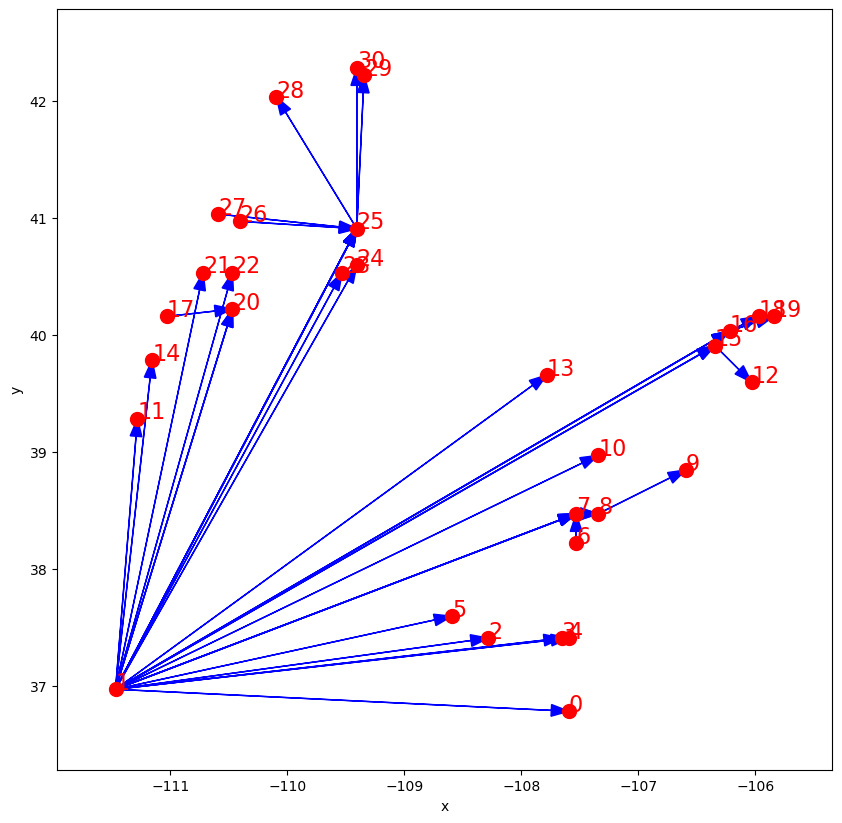

In [7]:
from landlab.plot.graph import plot_graph, plot_links
import matplotlib.pyplot as plt 

f, ax = plt.subplots(figsize=(10, 10))

plot_links(nmg, as_arrow=True, with_id=False) # looks like the link directions are messed up...
plot_graph(nmg, "node", with_id=True)

The link directions seem to be not correct, but since I use the flow directors to determine the contributing reservoirs for every downstream reservoir, we can ignore the link directions for now. I tried flipping the geometries in the network shapefile, but that didn't seem to fix the link directions, and any further solutions might require either writing my own finction to import a shapefile as a `NetworkGridModel` or make changes to the `landlab.io.read_shapefile` function.

Add the additional fields (slope and river length) from the network shapefile.

In [8]:
# creating own slope calculation function, landlab's calc_grad uses default 
# generated length which doesn't work in this case, so have to generate own lengths (get it from generated reservoir network)

# read reservoir_network file
link_gdf = gpd.read_file("../data/reservoir_network/reservoir_network.shp")
link_gdf.head()

lengths = [link_gdf.loc[(link_gdf['from_name']==from_name), 'length'].median() for from_name, to_name in zip(nmg.at_link['from_name'], nmg.at_link['to_name'])]

slope = np.divide(
    np.abs(
        nmg.at_node['topographic__elevation'][nmg.node_at_link_head] - nmg.at_node['topographic__elevation'][nmg.node_at_link_tail]
    ), lengths
)

nmg.add_field(
    "river__slope",
    slope,
    at='link',
    unit='m/m',
    clobber=True
)
nmg.add_field(
    "river__length",
    lengths,
    at='link',
    unit='m',
    clobber=True
);

In [9]:
# add link river storage. Use an assumption - 
#   river is a half cylinder, with R being the hydraulic radius.
#   R = A/P; A = R * P ; where P is the wetted perimeter.
#   if river is a half cylinder, P = pi * R; 
#   A = pi * R^2
#   Storage = A * Length

A = np.pi * np.square(nmg.at_link["river__hydraulic_radius"])
S = A * nmg.at_link["river__length"]
storage_multiplier = 0.1 # fraction full in January, just so it doesn't take off multiple timesteps just to equilibriate

nmg.add_field(
    "river__storage",
    S * storage_multiplier,
    at='link',
    unit='m3',
    clobber=True
);

Now that the input fields are defined, let's load the in-situ data.

In [10]:
import xarray as xr

data = xr.open_dataset('TS_2015.nc')
data

<xarray.Dataset>
Dimensions:      (date: 366, DAM_NAME: 31)
Coordinates:
  * date         (date) datetime64[ns] 2015-01-01 2015-01-02 ... 2016-01-01
  * DAM_NAME     (DAM_NAME) object 'Big Sandy Dike' ... 'Willow Creek'
Data variables: (12/13)
    DAM_ID       (DAM_NAME, date) float64 ...
    storage      (DAM_NAME, date) float64 ...
    inflow       (DAM_NAME, date) float64 ...
    outflow      (DAM_NAME, date) float64 ...
    evaporation  (DAM_NAME, date) float64 ...
    elevation    (DAM_NAME, date) float64 ...
    ...           ...
    AGENCY_COD   (DAM_NAME) object ...
    LONG         (DAM_NAME) float64 ...
    LAT          (DAM_NAME) float64 ...
    TS_START     (DAM_NAME) datetime64[ns] ...
    TS_END       (DAM_NAME) datetime64[ns] ...
    INCONSISTE   (DAM_NAME) float64 ...

In [11]:
# convert units to m3 or m3/day
data['inflow'] = data['inflow'] * (24 * 60 * 60)
data['storage'] = data['storage'] * (24 * 60 * 60)
data['outflow'] = data['outflow'] * (24 * 60 * 60)

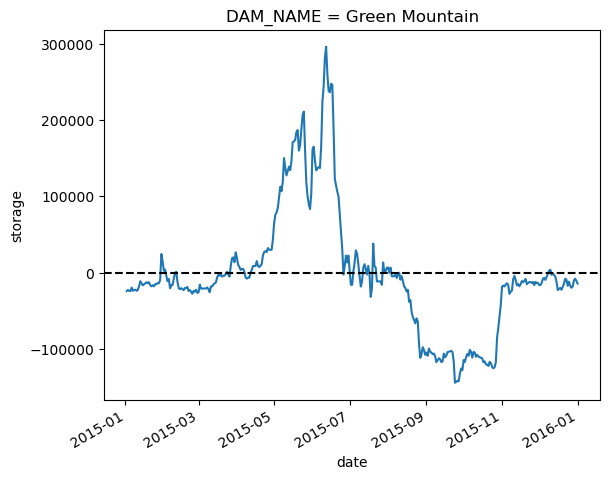

In [12]:
# add storage change
data = xr.merge([data.storage.diff(dim="date").rename("storage_change"), data])
data.storage.diff(dim="date").sel(DAM_NAME="Green Mountain").plot()
plt.axhline(0, linestyle='--', color='k')

For ease of running the for loop, lets same the time, inflows and storage changes in individual arrays.

In [13]:
time = data.date
inflows = np.array([data['inflow'].sel(DAM_NAME=name).data for name in nmg.at_node['name']]).T
storage_changes = np.array([data['storage_change'].sel(DAM_NAME=name).data for name in nmg.at_node['name']]).T

Let's create some placeholder arrays for saving the generated data.

In [14]:
node_data = {
    "reservoir__regulated_inflow": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__unregulated_inflow": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__release": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__total_inflow": np.full((len(time), len(nmg.nodes)), np.nan),
    "reservoir__upstream_storage_change": np.full((len(time), len(nmg.nodes)), np.nan)
}
link_data = {
    "river__storage": np.full((len(time), len(nmg.active_links)), np.nan),
    "river__regulated_flow": np.full((len(time), len(nmg.active_links)), np.nan),
    "river__release_inflow": np.full((len(time), len(nmg.active_links)), np.nan)
}

# We need to udpate the outflow field before running the model
last_release = [data['outflow'].sel(DAM_NAME=name).isel(date=1).data for name in nmg.at_node['name']]

nmg.at_node['reservoir__release'] = last_release

sr = StreamflowRegulation(nmg)

In [15]:
for idx, t, inflow, storage_change in zip(
    range(len(time[1:])),   # skip first value since it will be nan
    time[1:], 
    inflows[1:], 
    storage_changes[1:]
):
    sr.run_one_step(t, inflow, storage_change)
    
    # save node data
    # for node_id in enumerate(grid.nodes):
    for key in node_data:
        node_data[key][idx] = nmg.at_node[key]
    # for node_id in enumerate(grid.nodes):
    for key in link_data:
        link_data[key][idx] = nmg.at_link[key]

The model has run! Let's convert the data we just stored into an `xarray.Dataset` to create plots.

In [16]:
# convert the resulting data to a Dataset for visualization
import pandas as pd
import xarray as xr

node_ds = []

for var in node_data:
    da = xr.DataArray(
        node_data[var].T, 
        dims = ["DAM_NAME", "date"],
        coords=dict(
            DAM_NAME = nmg.at_node["name"],
            date = time
        ),
        name = var
    )
    node_ds.append(da)

node_ds = xr.merge(node_ds)
node_ds


link_ds = []

for var in link_data:
    da = xr.DataArray(
        link_data[var].T, 
        dims = ["FROM_DAM_NAME", "date"],
        coords=dict(
            FROM_DAM_NAME = nmg.at_link["from_name"],
            date = time
        ),
        name = var
    )
    link_ds.append(da)

link_ds = xr.merge(link_ds)
link_ds

<xarray.Dataset>
Dimensions:                (FROM_DAM_NAME: 43, date: 366)
Coordinates:
  * FROM_DAM_NAME          (FROM_DAM_NAME) <U20 'Navajo' ... 'Big Sandy Dike'
  * date                   (date) datetime64[ns] 2015-01-01 ... 2016-01-01
Data variables:
    river__storage         (FROM_DAM_NAME, date) float64 1.28e+08 ... nan
    river__regulated_flow  (FROM_DAM_NAME, date) float64 1.098e+05 ... nan
    river__release_inflow  (FROM_DAM_NAME, date) float64 3.848e+05 ... nan

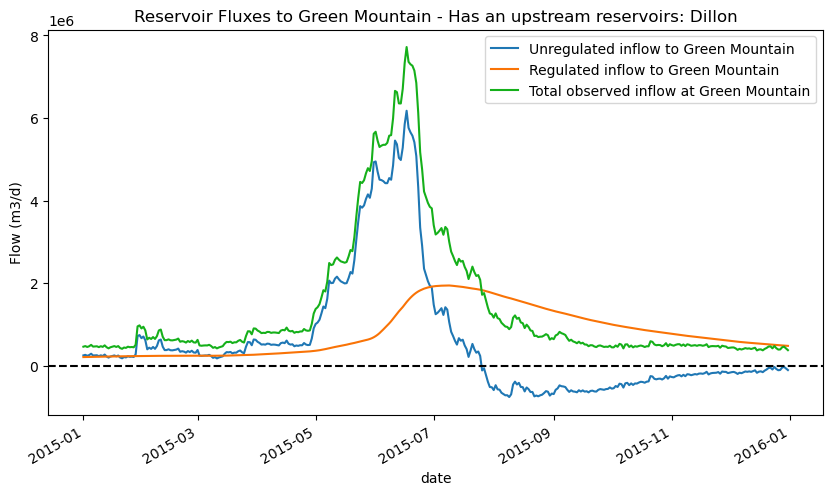

In [17]:
# Plot Upstream and Downstream fluxes
import matplotlib.pyplot as plt


downstream = "Green Mountain"

f, ax = plt.subplots(figsize=(10, 5))

node_ds['reservoir__unregulated_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Unregulated inflow to {downstream}')
node_ds['reservoir__regulated_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Regulated inflow to {downstream}', color='xkcd:orange')
node_ds['reservoir__total_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Total observed inflow at {downstream}', color='xkcd:green')

ax.axhline(0, linestyle='--', color='k')
ax.set_title(f"Reservoir Fluxes to {downstream} - Has an upstream reservoirs: Dillon")
ax.set_ylabel(f"Flow (m3/d)")
ax.legend();

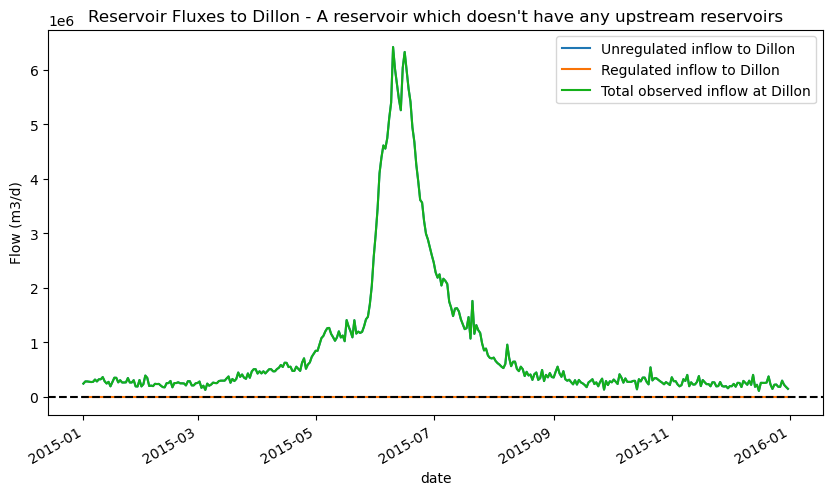

In [18]:
# Plot Upstream and Downstream fluxes
import matplotlib.pyplot as plt

downstream = "Dillon"

f, ax = plt.subplots(figsize=(10, 5))

node_ds['reservoir__unregulated_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Unregulated inflow to {downstream}')
node_ds['reservoir__regulated_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Regulated inflow to {downstream}', color='xkcd:orange')
node_ds['reservoir__total_inflow'].sel(DAM_NAME=downstream).plot(ax=ax, label=f'Total observed inflow at {downstream}', color='xkcd:green')

ax.axhline(0, linestyle='--', color='k')
ax.set_title(f"Reservoir Fluxes to {downstream} - A reservoir which doesn't have any upstream reservoirs")
ax.set_ylabel(f"Flow (m3/d)")
ax.legend();

## Things that worked
- The component is able to correctly represent the regulated inflow to reservoirs that have no upstream reservoirs, which should be 0 – as is the case for the Dillon reservoir.
- Given an upstream release event, the component is able to route the flow through the connecting river segment, and drain the water to the downstream reservoir using the linear storage model.
- For a downstream reservoir, and its contributing upstream reservoir(s), the component is able to model the incoming regulated flow into the downstream reservoir, that can be seen as reduced flow during the wet period, and higher flow during the dry period.

## Things to improve
- Assumption that Unregulated flow and Regulated flow can be partitioned at reservoir contradict with the assumption of the river flow model. The outflow from the river into a downstream reservoir depends on the storage of the river (higher storage, more outflow); and the "unregulated flow" that will be coming into the reservoir will also increase the storage of the river, leading to higher flows. Here we see that the river flow wanes after a release event, which should be more sharp, because of increasing storage of river due to unregulated flow. 
    - Example of the Willow Creek reservoir: 
    - ![](../results/river_fluxes/from_willow_creek.png)
- The inflow data used in this model was the in-situ observed inflow at reservoirs. This inflow already includes the upstream regulation, and hence is not the "natural" inflow. The "natural" inflow can only be obtained by modeling the inflow, assuming that there are no reservoirs in place. Partitioning this theoretical "natural" inflow into its regulated and unregulated components will make more sense, and likely produce a more coeherent picture of the river regulation in the reservoir network.
- The above stated reason can lead to partitioned inflow to become negative, which is not realistically possible, as is the case for the unregulated inflow to the Dillon reservoir.

## Conclusions and Way forward
- The final goal of this model is to use non-daily satellite estimates, that can have higher uncertainties, to model a reservoir network where the operations of upstream reservoirs dictates the incoming flow to downstream reservoirs. Using in-situ data, the developed component was tested, and it was seen that it can 
- The river routing algorithm paramters have to be determined based on more rigorous methods, instead of using constant values throughout the network (such as constant manning's n).has 
- Use the SWORDS ([DOI](https://doi.org/10.5281/zenodo.3898570)) dataset, which is designed to work with the SWOT satellite data. This dataset breaks down the rivers in reaches of 10 km each, or nodes at 200 m distances. This can be used to simulate the routed flow through the river network in a more rigorous way.


## Software availability
- Additional notebooks, and the `StreamflowRegulation` module can be found at: [github.com/pritamd47/ReservoirNetwork](https://github.com/pritamd47/ReservoirNetwork)